In [1]:
import matplotlib.pyplot as plt
import os, sys
from ase.io import read
from ase.units import Hartree

import time
import rascal
import json

from ase.io import read, write
from ase.visualize import view
import numpy as np
import sys


In [2]:
from rascal.representations import SphericalExpansion, SphericalInvariants
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from rascal.utils import (WignerDReal, ClebschGordanReal, 
                          spherical_expansion_reshape, spherical_expansion_conjugate,
                          lm_slice, real2complex_matrix, xyz_to_spherical, spherical_to_xyz)
from rascal.utils.cg_utils import _rotation as rotation

In [3]:
from tqdm.notebook import tqdm
class tqdm_reusable:
    def __init__(self, *args, **kwargs):
        self._args = args
        self._kwargs = kwargs

    def __iter__(self):
        return tqdm(*self._args, **self._kwargs).__iter__()

In general, an atomistic property of interest may be indexed by N atomic indices $y_{i i_2 \ldots i_N}$ instead of just one. This calls for features that also have a similar behavior. Let's restrict to the case of two centers. An example of such a property is the Hamiltonian in the AO basis 
#### tilde indices for orbitals (don't confuse with nlm used for projection basis of features)
$\newcommand{\Hhat}{\hat{H}}$
$\newcommand{\te}{\tilde{a}}$
$\newcommand{\tn}{\tilde{n}}$
$\newcommand{\tl}{\tilde{l}}$
$\newcommand{\tm}{\tilde{m}}$
$\newcommand{\tlm}{\tl\tm}$
$\newcommand{\tnlm}{\tnl\tm}$
$\newcommand{\tnl}{\tn\tl}$
$\newcommand{\tnnlammu}{\tnl_1;\tnl_2;\lambda\mu}$


$$
\langle \te_1 \tnlm_1; \te_2 \tnlm_2 | \Hhat | A_{ii_2} \rangle
$$
represents the element the matrix correspoding to orbital $|\tnlm_1 \rangle$ centered on atom $i$ with species $|\te_1\rangle$ and the orbital $|\tnlm_2 \rangle$ centered on atom $i_2$ with species $|\te_2\rangle$. 

Following the CG iteration, we can transform to the coupled basis as 
$$
\langle \te_1 \tnl_1; \te_2 \tnl_2 | \Hhat | A_{ii_2}; \lambda \mu \rangle
$$

In line with the SA-GPR framework in atomistic ML, we learn the corresponding rotationally equivariant elements with features obeying the same symmetry
$$
\langle a_1 n_1 l_1; a_2 n_2; l_2 | \overline{\rho_{i i_2}^{\otimes 1}; \lambda\mu} \rangle = 
\sum_{m_1 m_2} 
\langle a_1 n_1 l_1 m_1 | g; \mathbf{r}_{i i_2} \rangle  \langle a_2 n_2 l_2 m_2 | \rho_i \rangle
\langle l_1m_1; l_2 m_2 | \lambda\mu \rangle
$$

This resembles closely the the NICE iteration, therefore we can easily increase the number of centers / correlation order.  [Nigam et al., 2021](http://arxiv.org/abs/2109.12083)]

Let's try to learn the hamiltonian of water molecules using an effective core potential (ECP) for oxygen and a basis which corresponds to 1s, 2s orbitals on Hydrogen and 1s, 2s, 2p$_x$, 2p$_y$,2p$_z$ + three 3p orbitals on Oxygen  that are then Loewdin orthogonalized

In [4]:
import sys
sys.path.append('/home/nigam/git/ncenter-reps/ncnice/')

In [5]:
from hamiltonians import *
from representations import * 
from models import * 

In [10]:
spherical_expansion_hypers = {
    "interaction_cutoff": 4,
    "max_radial": 8,
    "max_angular": 6,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
}
CG = ClebschGordanReal(spherical_expansion_hypers["max_angular"])
abc = np.random.uniform(size=(3))*np.pi
WD = WignerDReal(spherical_expansion_hypers["max_angular"], *abc)

### Load frames, orbitals, orthogonal fock matrices 

In [11]:
N=400
frames = read('../data/water-example/water_coords_1000.xyz', ':'+str(N))
for i in range(len(frames)):
    frames[i].cell= [40,40,40]
    frames[i].positions+=20
    frames[i].pbc=False
    
orbs = json.loads(json.load(open('../data/water-example/water_orbs.json', "r")))
fock = np.load('../data/water-example/water_fock.npy', allow_pickle=True)
overlap =  np.load('../data/water-example/water_overlap.npy', allow_pickle=True)

The matrices calculated by PySCF, for l=1 orbitals, are ordered in a way that m=1, -1, 0. These need to be reordered so they are organized like the rest of the orbitals with m= -l, -l+1, ..., l-1, l

In [12]:
for i in range(len(frames)):
    fock[i] = fix_pyscf_l1(fock[i], frames[i], orbs)
    overlap[i] = fix_pyscf_l1(overlap[i], frames[i], orbs)

The fock matrices can be projected from the AO basis to the Loewdin orthogonalized basis 

In [13]:
ortho_fock =[]
for i in range(len(frames)):
    ortho_fock.append(lowdin_orthogonalize(fock[i], overlap[i]))
ortho_fock = np.asarray(ortho_fock)

### Decomposition of hamiltonian into different blocks

In [14]:
uncoupled_ortho_blocks = matrix_to_blocks(ortho_fock[213], frames[213], orbs)
coupled_ortho_blocks = couple_blocks(uncoupled_ortho_blocks, CG)

There are some additional symmetries when working with multiple centers, relating to permutation of labels which correlates to the symmetry of hamiltonians under exchange of identical atoms. See slides

### Verify the rotational behavior of predicted hamiltonian blocks

Invariance of $\lambda=0$ blocks

In [15]:
WD.rotate(coupled_ortho_blocks['diag'][(2,0,2,0)][0]) - coupled_ortho_blocks['diag'][(2,0,2,0)][0]

array([[0.]])

In [16]:
frame = frames[213]

feats = do_full_features([frame], orbs, spherical_expansion_hypers, 2, CG, scale=1e3)

### Fitting and predicting 

In [17]:
print("Fitting model")
FR = FockRegression(orbs, alpha=1e-8, fit_intercept="auto")
FR.fit(feats, coupled_ortho_blocks)

print("Predicting model")
pred_coupled = FR.predict(feats)
pred = blocks_to_matrix(decouple_blocks(pred_coupled, CG), frame, orbs)

print("RMSE Hamiltonian", np.linalg.norm(ortho_fock[213]-pred)/np.sqrt(len(ortho_fock[213])))
print("MAE Eigenvalues", np.mean(np.abs(np.linalg.eigvalsh(ortho_fock[213])-np.linalg.eigvalsh(pred))))

Fitting model
Fitting  diag:         (2, 0, 2, 0)
Fitting  diag:         (2, 0, 3, 0)
Fitting  diag:         (2, 0, 2, 1)
Fitting  diag:         (2, 0, 3, 1)
Fitting  diag:         (2, 0, 4, 1)
Fitting  diag:         (3, 0, 3, 0)
Fitting  diag:         (3, 0, 3, 1)
Fitting  diag:         (3, 0, 4, 1)
Fitting  diag:         (2, 1, 3, 0)
Fitting  diag:         (2, 1, 2, 1)
Fitting  diag:         (2, 1, 3, 1)
Fitting  diag:         (2, 1, 4, 1)
Fitting  diag:         (3, 1, 3, 1)
Fitting  diag:         (3, 1, 4, 1)
Fitting  diag:         (4, 1, 4, 1)
Fitting  diag:         (6, 0, 6, 0)
Fitting  diag:         (6, 0, 7, 0)
Fitting  diag:         (7, 0, 7, 0)
Fitting offd_p:         (6, 0, 6, 0)
Fitting offd_p:         (6, 0, 7, 0)
Fitting offd_p:         (7, 0, 7, 0)
Fitting offd_m:         (6, 0, 6, 0)
Fitting offd_m:         (6, 0, 7, 0)
Fitting offd_m:         (7, 0, 7, 0)
Fitting  hete:         (2, 0, 6, 0)
Fitting  hete:         (2, 0, 7, 0)
Fitting  hete:         (3, 0, 6, 0)
Fitting 

### Predict a structure that is rotated and atoms permuted 

In [18]:
frame_rotperm = frame.copy()
iperm = np.arange(len(frame.numbers), dtype=int)
np.random.shuffle(iperm)
frame_rotperm.numbers = frame_rotperm.numbers[iperm]
frame_rotperm.positions = frame_rotperm.positions[iperm]
print(frame_rotperm.symbols)

abc = np.random.uniform(size=(3))*np.pi
WD = WignerDReal(spherical_expansion_hypers["max_angular"], *abc)
WD.rotate_frame(frame_rotperm)

OH2


Atoms(symbols='OH2', pbc=False, cell=[[22.302288902481273, -15.757861764650926, -29.228371530354092], [-21.43802789237658, -33.7207907390102, 1.821875962179701], [-25.35781673953704, 14.649166001586472, -27.246707427908028]])

In [19]:
frame_list = [frame, frame_rotperm ]
view(frame_list)

In [20]:
feats_rotperm = do_full_features([frame_rotperm], orbs, spherical_expansion_hypers, 2, CG, scale=1e3)
pred_rotperm = blocks_to_matrix(decouple_blocks(FR.predict(feats_rotperm), CG), frame, orbs)

print("RMSE Hamiltonian (pred)", np.linalg.norm(pred_rotperm-pred)/np.sqrt(len(ortho_fock[213])))
print("MAE Eigenvalues (pred)", np.mean(np.abs(np.linalg.eigvalsh(pred_rotperm)-np.linalg.eigvalsh(pred))))


RMSE Hamiltonian (pred) 0.5794303454672092
MAE Eigenvalues (pred) 8.770761894538737e-16


Text(0.5, 0, 'k')

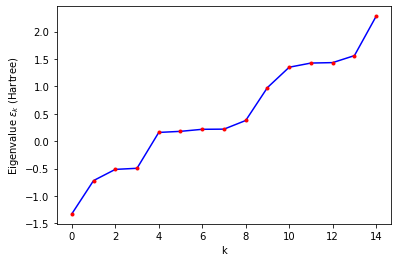

In [21]:
plt.plot(np.linalg.eigvalsh(pred), 'b')
plt.plot(np.linalg.eigvalsh(pred_rotperm), 'r.')
plt.ylabel(r'Eigenvalue $\epsilon_k$ (Hartree)')
plt.xlabel('k')

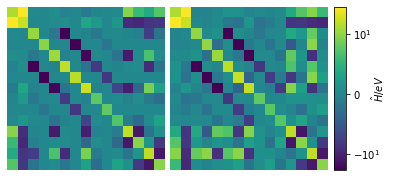

In [22]:
mats = [pred*Hartree, pred_rotperm*Hartree]
import matplotlib.gridspec as gridspec
import matplotlib
fig= plt.figure(figsize=(9,3))
gs = gridspec.GridSpec(1, 4, width_ratios=(1,1,0.08, 1))
gs.update(wspace=0.05)
gs.update(hspace=0.01)
# gs.update(width_ratios='1:1')
ax1 = plt.subplot(gs[0, 0], )
ax2 = plt.subplot(gs[0, 1])
ax4 = plt.subplot(gs[0, 2])

for i,ax in enumerate([ax1,ax2]):
    im = ax.matshow(mats[i], norm=matplotlib.colors.SymLogNorm(linthresh=5, linscale=1), aspect="auto")
    ax.axis('off')

c = fig.colorbar(im,fraction=0.026, pad=0.046,cax=ax4,orientation="vertical")
c.set_label(r'$\hat{H}/ eV$', rotation=90, labelpad=-10, y=0.5)
ax= c.ax
# ax.xaxis.set_ticks_position('right')
# ax.xaxis.set_label_position('right')
# ax.text(1.2,2,r'$\hat{H}(eV)$', fontsize=13, rotation=90)
# c.ax.xaxis.set_ticks(minor_ticks, minor=True) 
c.set_ticks([[-100., -500., -10.,   0.,   10.,  100., 500.]])
ax.xaxis.set_tick_params(pad=-2)

### Let's do this for a larger dataset 

In [23]:
coupled_ortho_blocks, slices = matrix_list_to_blocks(ortho_fock[:50], frames[:50], orbs, CG)

In [24]:
train_slices = slice_fraction(coupled_ortho_blocks, tf=0.8)

In [25]:
feats = do_full_features(frames[:50], orbs, spherical_expansion_hypers, 2, CG, scale=1e3)

### Run regression

In [26]:
FR = FockRegression(orbs, alphas = np.geomspace(1e-8,1e8, 12))

In [27]:
FR.fit(feats, coupled_ortho_blocks, train_slices, progress=tqdm)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
pred_blocks = FR.predict(feats, progress=tqdm)
pred_matrix = blocks_to_matrix_list(pred_blocks, frames, slices, orbs, CG)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

##### pred_matrix is a list of all predictions. Remember we trained on the first 40 structures! 

### Post diagnostics 

How does the eigenvalue spectum compare? What's the error on the HOMO-LUMO gaps, which blocks do better than others? 